# 📈📉Predicción del índice S&P 500 mediante redes LSTM

## Introducción

El objetivo de este proyecto es aplicar técnicas de *Deep Learning* para el análisis y la predicción de series temporales financieras, utilizando datos históricos del índice S&P 500.

A lo largo del notebook se sigue un flujo de trabajo típico de *Data Science*:
1. Carga y exploración de datos históricos.
2. Preprocesado y transformación de la serie temporal.
3. Reducción de ruido mediante agregación semanal.
4. Construcción de ventanas temporales para aprendizaje secuencial.
5. Diseño y entrenamiento de un modelo LSTM.
6. Evaluación del modelo y análisis de resultados.
7. Predicción de valores futuros.

El uso de redes LSTM (Long Short-Term Memory) está motivado por su capacidad para capturar dependencias temporales de largo plazo, especialmente relevantes en datos financieros.

Este notebook está planteado como un proyecto de portafolio, priorizando:
- Claridad en el proceso.
- Reproducibilidad.
- Buenas prácticas en el tratamiento de series temporales.

## Importación de librerías y configuración del entorno

En esta celda se importan todas las librerías necesarias para el proyecto, incluyendo herramientas para análisis de datos, visualización y deep learning.  
También se muestran las versiones de las principales dependencias para garantizar la reproducibilidad del análisis.


In [110]:
import sys
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
import keras

print("Versión de Python: ",sys.version)
print("\nVersion de Numpy: ",np.__version__)
print("\nVersión de Keras: ",keras.__version__)
print("\nVersión de Tensorflow: ",tf.__version__)

#sns.set(style='whitegrid')
#plt.style.use("fivethirtyeight")
%matplotlib inline

Versión de Python:  3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]

Version de Numpy:  2.4.1

Versión de Keras:  3.13.1

Versión de Tensorflow:  2.20.0


## Carga de datos históricos del S&P 500

Se cargan los datos históricos del índice S&P 500 utilizando `pandas`.  
El objetivo es trabajar con una serie temporal larga que permita entrenar un modelo capaz de capturar tendencias de largo plazo.


In [111]:
import pandas as pd

url_backup = 'https://www.kaggle.com/datasets/paveljurke/s-and-p-500-gspc-historical-data?select=sap500.csv'
local_filename = 'sap500.csv'

try:
    df = pd.read_csv(local_filename)
    origen = f'archivo local: {local_filename}'
except FileNotFoundError:
    print(f'⚠️ No se ha encontrado el archivo local `{local_filename}`. Intentando descargar desde la URL...')
    df = pd.read_csv(url_backup)
    origen = 'descarga online desde YahooFinance)'

print('✅ Datos cargados desde', origen)
print('Número de filas y columnas:', df.shape)
display(df.head(10))
display(df.tail(10))

# Mostrar información del DataFrame
print("Información del DataFrame:")
print(df.info())

print("\nResumen de estadísticas")
display(df.describe())

print("\nValores nulos en el DataFrame:")
print(df.isna().sum().sort_values(ascending=False))

df['Date'] = df['Date'].astype('datetime64[ns]')

print("\nTipo de datos de las columnas después de la conversión:")
print(df.dtypes)

✅ Datos cargados desde archivo local: sap500.csv
Número de filas y columnas: (24625, 6)


,Date,Open,High,Low,Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,0.0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,0.0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,0.0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,0.0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,0.0
5,1928-01-09,17.500000,17.500000,17.500000,17.500000,0.0
6,1928-01-10,17.370001,17.370001,17.370001,17.370001,0.0
7,1928-01-11,17.350000,17.350000,17.350000,17.350000,0.0
8,1928-01-12,17.469999,17.469999,17.469999,17.469999,0.0
9,1928-01-13,17.580000,17.580000,17.580000,17.580000,0.0


,Date,Open,High,Low,Close,Volume
24615,2025-12-30,6900.439941,6913.250000,6893.470215,6896.240234,3.309930e+09
24616,2025-12-31,6898.819824,6901.419922,6844.549805,6845.500000,3.261830e+09
24617,2026-01-02,6878.109863,6894.870117,6824.310059,6858.470215,4.184120e+09
24618,2026-01-05,6892.189941,6920.379883,6891.560059,6902.049805,5.771930e+09
24619,2026-01-06,6908.029785,6948.689941,6904.020020,6944.819824,5.509680e+09
24620,2026-01-07,6945.069824,6965.689941,6919.189941,6920.930176,5.214480e+09
24621,2026-01-08,6914.109863,6931.279785,6899.330078,6921.459961,5.333200e+09
24622,2026-01-09,6927.830078,6978.359863,6917.640137,6966.279785,5.163900e+09
24623,2026-01-12,6944.120117,6986.330078,6934.069824,6977.270020,5.019040e+09
24624,2026-01-13,6977.410156,6985.830078,6938.770020,6963.740234,5.091730e+09


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24625 entries, 0 to 24624
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    24625 non-null  object 
 1   Open    24625 non-null  float64
 2   High    24625 non-null  float64
 3   Low     24625 non-null  float64
 4   Close   24625 non-null  float64
 5   Volume  24625 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.1+ MB
None

Resumen de estadísticas


,Open,High,Low,Close,Volume
count,24625.000000,24625.000000,24625.000000,24625.000000,2.462500e+04
mean,716.712468,720.834158,712.327901,716.860739,9.631576e+08
std,1220.874690,1227.324272,1213.926141,1221.088329,1.677474e+09
min,4.400000,4.400000,4.400000,4.400000,0.000000e+00
25%,24.930000,24.930000,24.930000,24.930000,1.590000e+06
50%,103.489998,104.300003,102.580002,103.489998,2.196000e+07
75%,1088.849976,1096.560059,1079.079956,1089.189941,1.159400e+09
max,6977.410156,6986.330078,6938.770020,6977.270020,1.145623e+10



Valores nulos en el DataFrame:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Tipo de datos de las columnas después de la conversión:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object


## Exploración inicial de la serie temporal

Se realiza una primera inspección de los precios de cierre diarios desde 1995, comprobando el rango temporal, la estructura de los datos y la presencia de valores nulos.


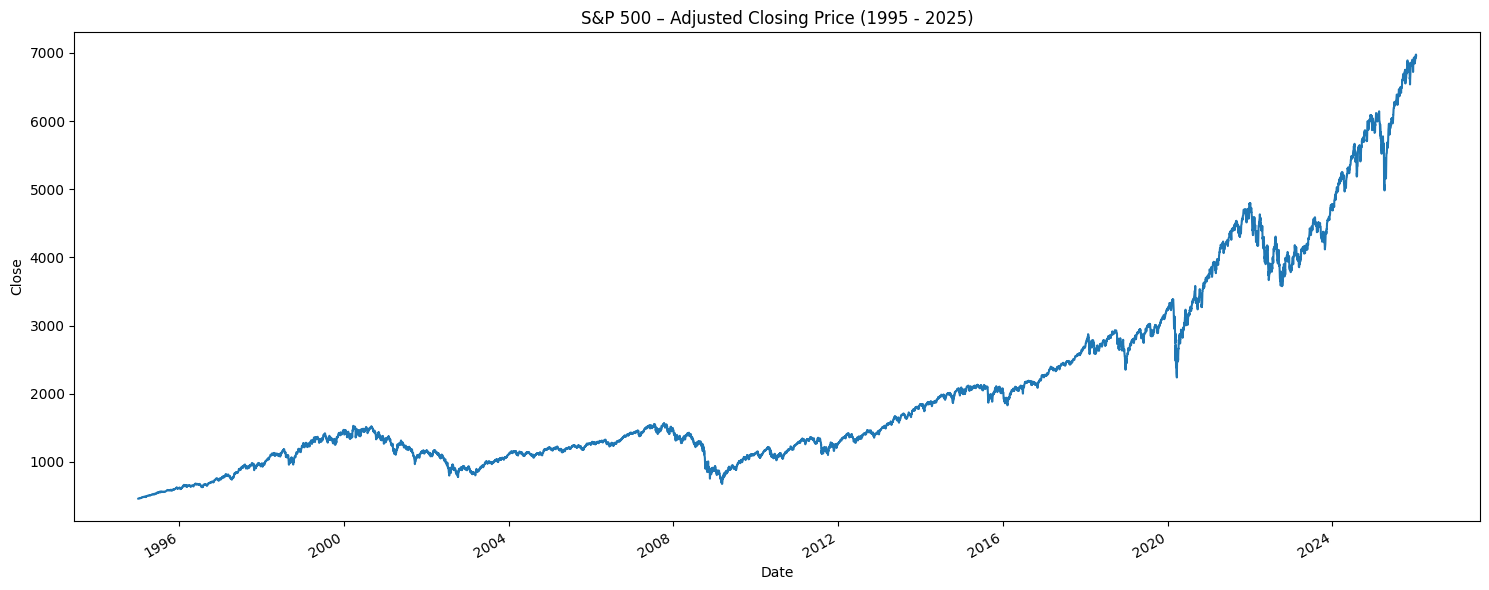

In [112]:
#Cierres diarios desde 1995

df = df.set_index('Date')

df_1995 = df.loc['1995-01-01':]

df_from_1995 = df_1995

plt.figure(figsize=(15, 6))

# Gráfico del precio ajustado de cierre
df_from_1995['Close'].plot()

plt.ylabel('Close')
plt.xlabel('Date')
plt.title('S&P 500 – Adjusted Closing Price (1995 - 2025)')

plt.tight_layout()
plt.show()

## Conversión de datos diarios a datos semanales

Para reducir el ruido propio de los datos diarios, se transforman los precios a frecuencia semanal, tomando como referencia el cierre de los viernes.


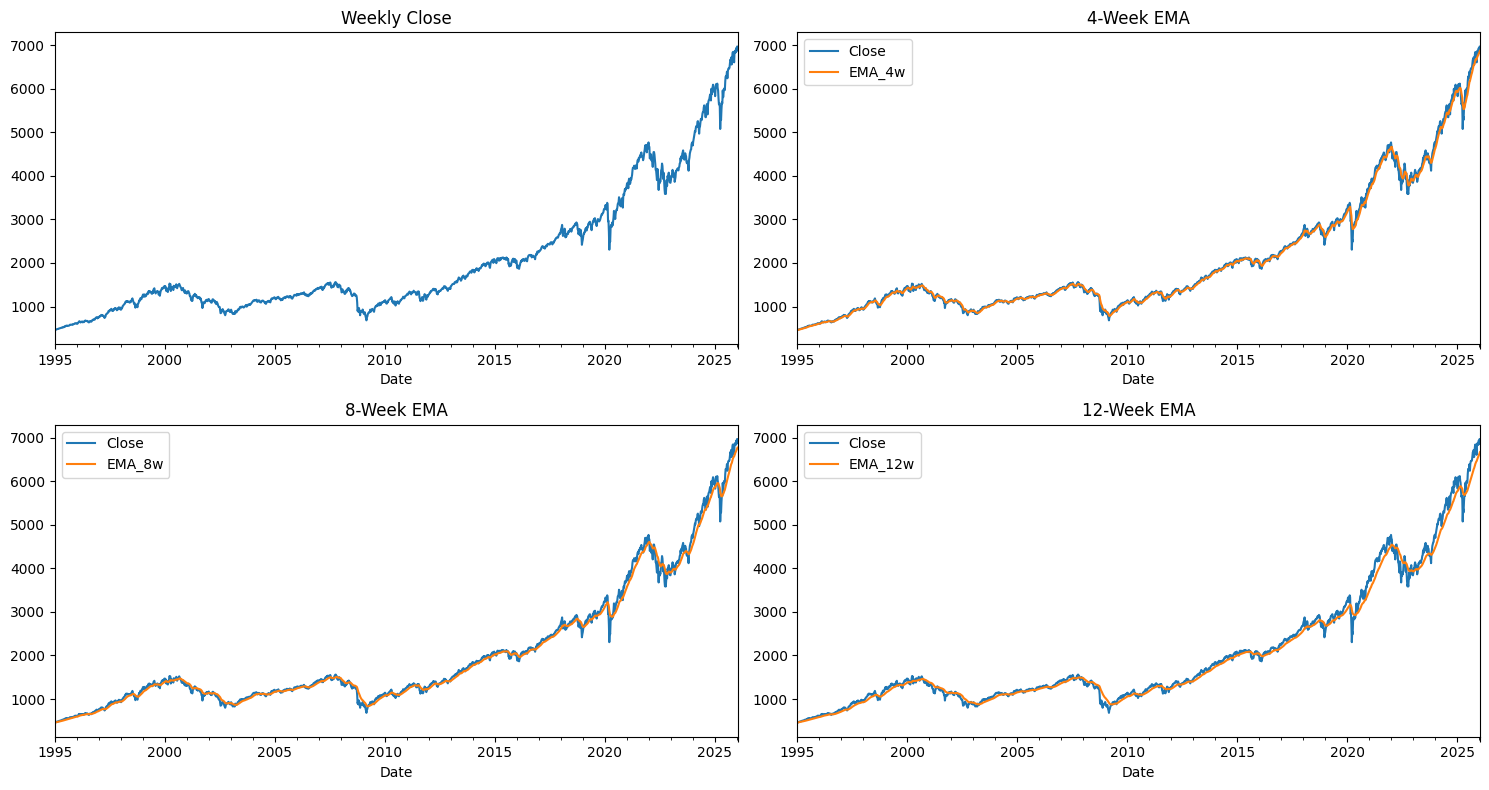

In [113]:
# Datos semanales (viernes)
df_weekly_1995 = df_from_1995.resample('W-FRI').last()

# Medias móviles exponenciales SEMANALES (exponential moving average) de 4, 8 y 12 semanas
ema_week = [4, 8, 12]  # 1, 2 y 3 meses aproximadamente

for ema in ema_week:
    df_weekly_1995[f"EMA_{ema}w"] = df_weekly_1995['Close'].ewm(ema).mean()

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

df_weekly_1995['Close'].plot(ax=axes[0, 0], title='Weekly Close') #Cierre semanal
df_weekly_1995[['Close', 'EMA_4w']].plot(ax=axes[0, 1], title='4-Week EMA')
df_weekly_1995[['Close', 'EMA_8w']].plot(ax=axes[1, 0], title='8-Week EMA')
df_weekly_1995[['Close', 'EMA_12w']].plot(ax=axes[1, 1], title='12-Week EMA')

plt.tight_layout()
plt.show()

## Visualización de precios de cierre diarios

Se representa gráficamente la evolución histórica del índice S&P 500 para identificar tendencias generales, ciclos de mercado y 
periodos de alta volatilidad mediante la media móvil exponencial (EMA), en temporalidad diaria.


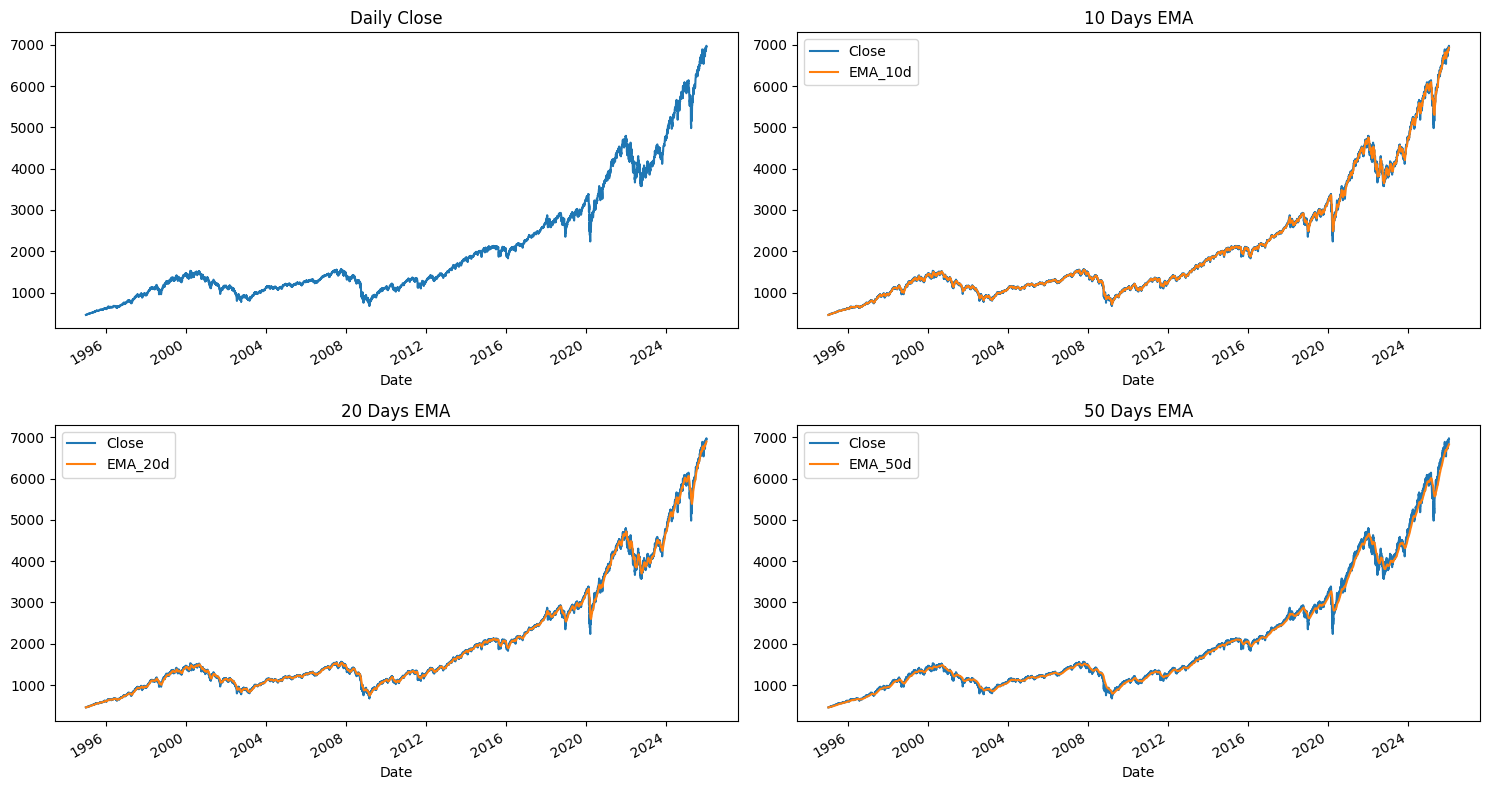

In [114]:
# Datos diarios
df_daily_1995 = df_from_1995.copy()

# Medias móviles exponenciales DIARIAS (exponential moving average) de 10, 20 y 50 días
ema_daily = [10, 20, 50]
for ema in ema_daily:
    df_daily_1995[f"EMA_{ema}d"] = df_daily_1995['Close'].ewm(span=ema, adjust='False').mean()

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

df_daily_1995['Close'].plot(ax=axes[0, 0], title='Daily Close') #Cierre diario
df_daily_1995[['Close', 'EMA_10d']].plot(ax=axes[0, 1], title='10 Days EMA')
df_daily_1995[['Close', 'EMA_20d']].plot(ax=axes[1, 0], title='20 Days EMA')
df_daily_1995[['Close', 'EMA_50d']].plot(ax=axes[1, 1], title='50 Days EMA')

plt.tight_layout()
plt.show()

## Obtención de cierres semanales

Se extraen los precios de cierre semanales de toda la serie histórica, que serán utilizados como base para entrenar el modelo de predicción.


In [115]:
# Cierres semanales de toda la serie histórica
df_weekly = df.resample('W-FRI').last()
display(df_weekly.head())
display(df_weekly.tail())

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0.0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0.0
1928-01-13,17.580000,17.580000,17.580000,17.580000,0.0
1928-01-20,17.480000,17.480000,17.480000,17.480000,0.0
1928-01-27,17.690001,17.690001,17.690001,17.690001,0.0


,Open,High,Low,Close,Volume
Date,,,,,
2025-12-19,6792.620117,6840.020020,6792.620117,6834.500000,8.554470e+09
2025-12-26,6936.020020,6945.770020,6921.600098,6929.939941,2.586550e+09
2026-01-02,6878.109863,6894.870117,6824.310059,6858.470215,4.184120e+09
2026-01-09,6927.830078,6978.359863,6917.640137,6966.279785,5.163900e+09
2026-01-16,6977.410156,6985.830078,6938.770020,6963.740234,5.091730e+09


## Preprocesado: escalado y creación de ventanas temporales

Los datos se escalan utilizando `MinMaxScaler` y se crean ventanas temporales deslizantes.  
Este paso es fundamental para que el modelo LSTM pueda aprender dependencias temporales.


In [116]:
# Usar datos semanales (cierre del viernes)
df_weekly = df.resample('W-FRI').last()

# Crear un nuevo DataFrame solo con Close
data = df_weekly[['Close']].dropna()

dataset = data.values

training_data_len = int(np.ceil(len(dataset) * 0.95))
print(training_data_len)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

train_data = scaled_data[:training_data_len]

x_train = []
y_train = []

window = 250 # semanas

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape para LSTM [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


4861
[[0.00190322]
 [0.00190322]
 [0.00189173]
 ...
 [0.98451428]
 [1.        ]
 [0.99963522]]


## Definición del modelo LSTM

Se define la arquitectura del modelo LSTM, incluyendo capas recurrentes y capas densas.


In [117]:
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(20))
model.add(Dense(1))

model.summary()


c:\Users\Nicolás_García\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 250, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,289 (458.16 KB)

 Trainable params: 117,289 (458.16 KB)

 Non-trainable params: 0 (0.00 B)

## Configuración de hiperparámetros

Se establecen los principales hiperparámetros del entrenamiento, como el optimizador y el número de épocas, permitiendo experimentar fácilmente con distintas configuraciones.


In [76]:
optimizer_name = "adam"# TODO: prueba a cambiarlo
loss_name = "mean_squared_error"
metrics_list = ["mean_absolute_error"]  # TODO: puedes añadir más métricas si quieres

model.compile(
    optimizer=optimizer_name,
    loss=loss_name,
    metrics = metrics_list
)

## Entrenamiento del modelo

El modelo se entrena con los datos históricos, almacenando el histórico de pérdidas para analizar posteriormente su evolución.

In [77]:
epochs = 15
batch_size = 32

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - loss: 4.6577e-04 - mean_absolute_error: 0.0094
Epoch 2/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - loss: 5.3077e-05 - mean_absolute_error: 0.0041
Epoch 3/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 4.6209e-05 - mean_absolute_error: 0.0037
Epoch 4/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 8.0904e-05 - mean_absolute_error: 0.0060
Epoch 5/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 4.4637e-05 - mean_absolute_error: 0.0039
Epoch 6/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 4.0086e-05 - mean_absolute_error: 0.0034
Epoch 7/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 4.4020e-05 - mean_absolute_error: 0.0040
Epoch 8/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - loss: 3.9676e-05 - mean_absolute_error: 0.0036
Epoch 9/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - loss: 4.4058e-05 - mean_absolute_error: 0.0042
Epoch 10/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - loss: 

## Evaluación del proceso de entrenamiento

Se analizan las métricas de entrenamiento para comprobar si el modelo converge correctamente y si existen indicios de sobreajuste.


dict_keys(['loss', 'mean_absolute_error'])


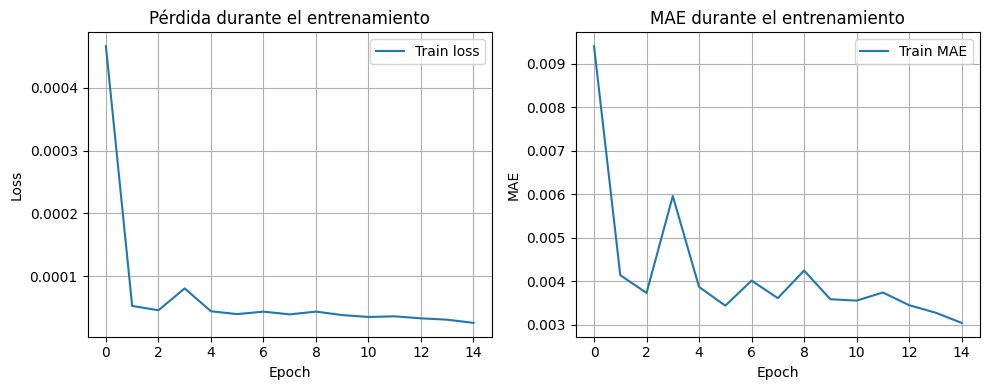

In [78]:
history_dict = history.history
print(history_dict.keys())

plt.figure(figsize=(10,4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento")
plt.legend()
plt.grid(True)

# Accuracy (si existe)
if "mean_absolute_error" in history_dict:
    plt.subplot(1, 2, 2)
    plt.plot(history_dict["mean_absolute_error"], label="Train MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("MAE durante el entrenamiento")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Preparación del conjunto de test

Se construye el conjunto de datos de test respetando la estructura temporal, lo que permite evaluar el modelo de forma realista.


In [79]:
test_data = scaled_data[training_data_len - window:, :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f"RMSE: {rmse:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
RMSE: 133.34


## Comparación entre valores reales y predicciones

Se comparan visualmente los valores reales del índice con las predicciones del modelo para evaluar su rendimiento.


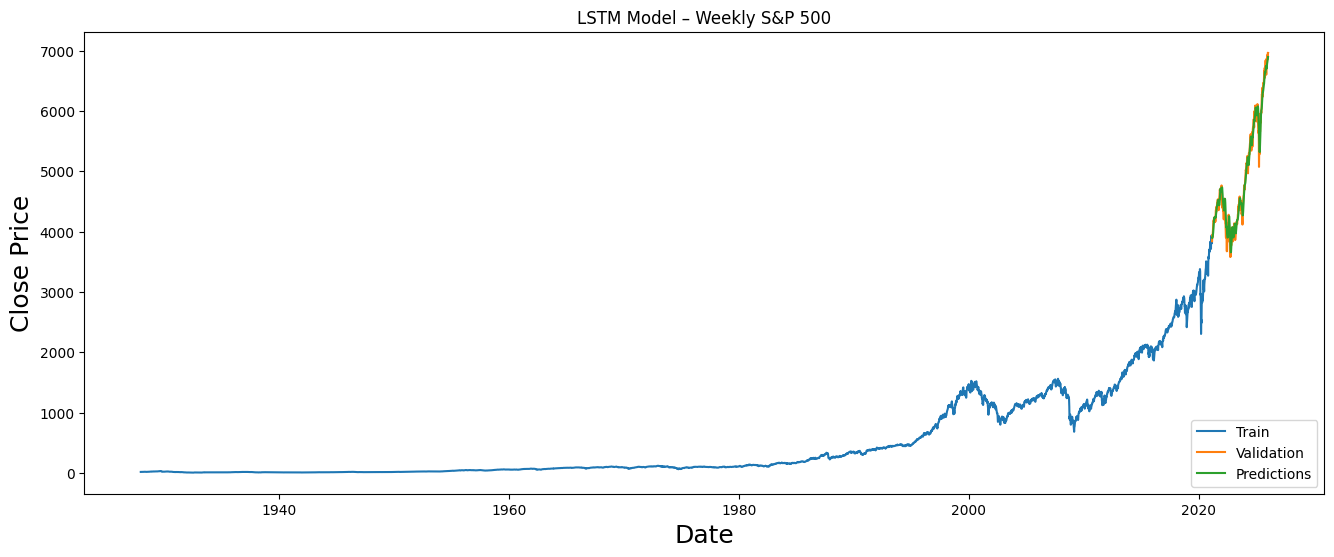

,Close,Predictions
Date,,
2021-03-05,3841.939941,3900.453857
2021-03-12,3943.340088,3891.994385
2021-03-19,3913.100098,3907.801025
2021-03-26,3974.540039,3922.039551
2021-04-02,4019.870117,3948.399902
...,...,...
2025-12-19,6834.500000,6793.525391
2025-12-26,6929.939941,6813.671387
2026-01-02,6858.470215,6851.451660


In [80]:
train = data.iloc[:training_data_len]
valid = data.iloc[training_data_len:]
valid = valid.copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16, 6))
plt.title('LSTM Model – Weekly S&P 500')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

display(valid)

## Predicción de semanas futuras

Finalmente, se utiliza el modelo entrenado para predecir varias semanas futuras del índice S&P 500.  
Las predicciones se reescalan a su valor original para facilitar su interpretación.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicciones próximas 4 semanas:


,Predicted Close
2026-01-23,6921.661621
2026-01-30,6927.502930
2026-02-06,6925.038574
2026-02-13,6918.368164


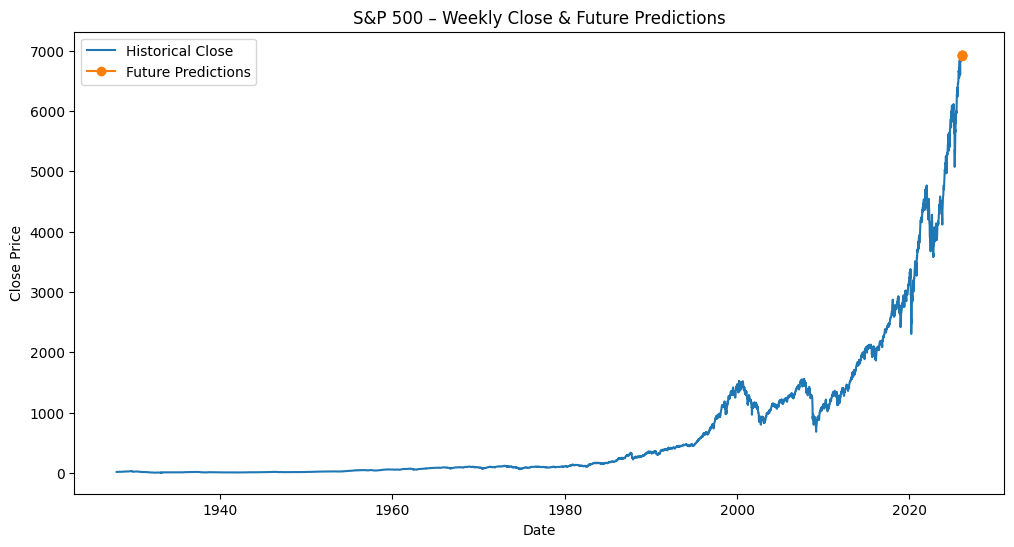

In [81]:
last_weeks = scaled_data[-window:].reshape(-1)  # última ventana
input_seq = last_weeks.copy()
future_predictions = []

for i in range(4):  # predecir 4 semanas
    x_input = input_seq[-window:].reshape(1, window, 1)
    pred = model.predict(x_input)[0,0]
    future_predictions.append(pred)
    input_seq = np.append(input_seq, pred)  # añadir predicción a la secuencia

# Escalar de vuelta
future_predictions = np.array(future_predictions).reshape(-1,1)
future_predictions = scaler.inverse_transform(future_predictions)

# Fechas futuras
last_date = df_weekly.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=4, freq='W-FRI')
pred_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predicted Close'])

print("Predicciones próximas 4 semanas:")
display(pred_df)

# Visualización con futuras predicciones
plt.figure(figsize=(12,6))
plt.plot(df_weekly['Close'], label='Historical Close')
plt.plot(pred_df['Predicted Close'], label='Future Predictions', marker='o')
plt.title('S&P 500 – Weekly Close & Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## Conclusiones y trabajo futuro

En este proyecto se ha desarrollado un modelo LSTM para la predicción del índice S&P 500 a partir de datos históricos semanales.  
Los resultados muestran que el modelo es capaz de capturar la tendencia general de la serie, aunque presenta limitaciones inherentes a la naturaleza altamente impredecible de los mercados financieros.

Desde un punto de vista de *Data Science*, los aspectos más relevantes del proyecto son:
- La correcta preparación de la serie temporal mediante escalado y ventanas deslizantes.
- La reducción de ruido usando datos semanales en lugar de diarios.
- El uso de un modelo secuencial adecuado para dependencias temporales.

### Posibles mejoras y extensiones
Este trabajo puede ampliarse en varias direcciones:
- Inclusión de variables exógenas (volumen, tipos de interés, inflación, indicadores macroeconómicos).
- Comparación con modelos clásicos de series temporales (ARIMA, Prophet).
- Optimización de hiperparámetros mediante *Grid Search* o *Bayesian Optimization*.
- Evaluación con métricas adicionales (RMSE, MAE).
- Predicciones probabilísticas o intervalos de confianza.

En conclusión, este proyecto demuestra un enfoque completo de *Data Science aplicado a series temporales*, combinando análisis de datos, preprocesado, modelado y evaluación en un contexto realista.
